In [2]:
import numpy as np
import matplotlib as matlib
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.stats import multivariate_normal
from scipy.sparse import spdiags
from scipy.sparse import kron
from mpl_toolkits.mplot3d import Axes3D
import time
import random
from sklearn.decomposition import PCA, NMF
import scipy.sparse as sp
import scipy.linalg as linalg
from numpy.random import default_rng
import matplotlib.patches as mpatches
import ot
matlib.rcParams['text.usetex'] = True
import Gradient;

In [6]:
##centered at 2, 2
N = 71; S = 10;
dx = S/N; dy = S/N;
X = [];
for i in range(1, N):
    for j in range(1, N):
        X.append([2-S/2 + dx*i, 2-S/2 + dy*j]);
X = np.array(X);

##another finer and larger discretization used to compite the W2 loss
N2 = 75; S2 = 15;
dx2 = S2/N2; dy2 = S2/N2;
bounds = [[-5.5, 9.5], [-5.5, 9.5]];
Xi = [i for i in np.arange(bounds[0][0]+dx2, bounds[0][1]-0.01, dx2)];
Yi = [i for i in np.arange(bounds[1][0]+dx2, bounds[1][1]-0.01, dy2)];
Xi = np.array(Xi); Yi = np.array(Yi);
xv, yv = np.meshgrid(Xi, Yi, sparse=False, indexing ='ij');
X2 = np.zeros((len(Xi)*len(Yi), 2));
X2[:,0] = xv.reshape(len(Xi)*len(Yi), order='F');
X2[:,1] = yv.reshape(len(Xi)*len(Yi), order='F');
costM = ot.dist(X2, X2);

In [13]:
k = 2;
A = Gradient.discretize(N, dx, dy);
w_true = np.array([0.3]);
mu_true = np.array([[1, 3], [3, 2]]);
ytruth = Gradient.model(X, k, mu_true, w_true);
initial = np.array([0.8, 4, 4, 4, 3]);
w_initial, mu_initial = Gradient.to2(initial, 2)

In [29]:
initial = np.array([4.4, 4]); std_lr=1.8; w2_lr=400; l2_lr=.4;
w = np.array([.3]);
std_steps = [initial];
w2_steps = [initial];
l2_steps = [initial];
std_para = initial; w2_para = initial; l2_para = initial;
for i in range(4):
    print(i);
    _,std_direct = Gradient.gradient_mu1_all(X, w, std_para, np.array([3, 2]), ytruth);
    w2_direct = Gradient.Natural_dir_mu1(X, N, w, 
                 np.array([w2_para, np.array([3, 2])]), ytruth, A, 2);
    l2_direct = Gradient.l2_Natural_dirFull_mu1(X, np.array([l2_para, np.array([3, 2])]), 
                                    w, N, ytruth);
    std_para = std_para - std_lr*std_direct;
    w2_para = w2_para - w2_lr*w2_direct;
    l2_para = l2_para + l2_lr*l2_direct;
    std_steps.append(std_para);
    w2_steps.append(w2_para);
    l2_steps.append(l2_para);  
std_steps = np.array(std_steps);
w2_steps = np.array(w2_steps);
l2_steps = np.array(l2_steps);

0
1
2
3


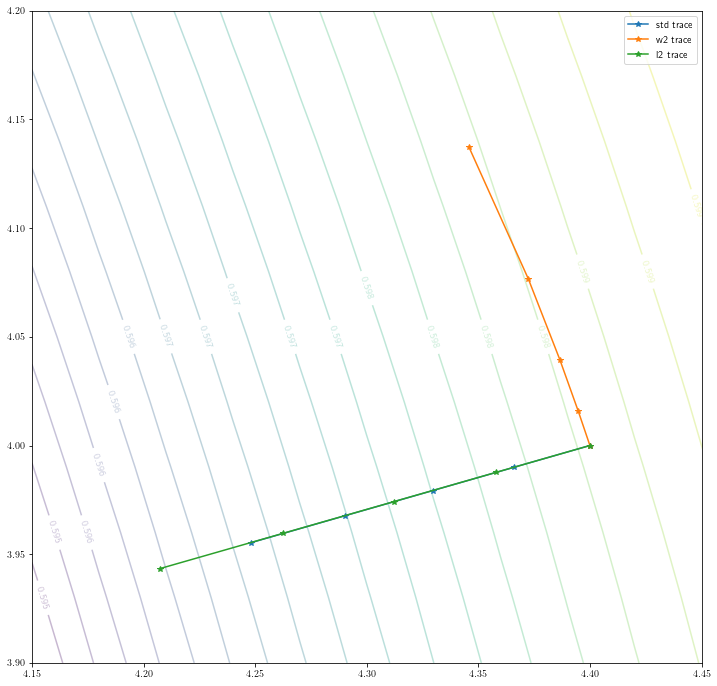

In [30]:
xrange = [initial[0]-0.25, initial[0]+0.05];
yrange = [initial[1]-0.1, initial[1]+0.2];
grid1 = (xrange[1]-xrange[0])/10;
grid2 = (yrange[1]-yrange[0])/10;
x = np.arange(xrange[0],xrange[1]+grid1,grid1);
y = np.arange(yrange[0],yrange[1]+grid2,grid2);
P,Q = np.meshgrid(x,y)
Z = np.zeros((x.size, y.size));
for i in range(x.size):
    for j in range(y.size):
        Z[i, j] = Gradient.loss(X, 2, np.array([np.array([grid1*i+xrange[0], grid2*j+yrange[0]]), np.array([3, 2])]), 
                          np.array([.3]), ytruth);
fig, ax = plt.subplots(figsize=(12, 12));
level = np.arange(Z.min(), Z.max(), (Z.max()-Z.min())/20);
CS = ax.contour(P,Q,Z.T,levels = level, alpha=.3, zorder=0);
ax.clabel(CS, inline=True, fontsize=10);
plt.plot(std_steps[:, 0], std_steps[:, 1], '*-', label = 'std trace');
plt.plot(w2_steps[:, 0], w2_steps[:, 1], '*-', label = 'w2 trace');
plt.plot(l2_steps[:, 0], l2_steps[:, 1], '*-', label = 'l2 trace');
plt.xlim(xrange[0], xrange[1]);
plt.ylim(yrange[0], yrange[1]);
plt.legend();
savpath = "/Users/leiwanzhou/Desktop/l2_mix_4para/steps/together-trace-init4d44-N71-S10-C22"
plt.savefig(savpath, dpi=300);

In [14]:
def func_std_mu1(mu1, mu1_fix, lr):
    result = loss(X, 2, np.array([mu1, np.array([3, 2])]), 
                  np.array([.3]), ytruth);
    result += ((mu1-mu1_fix)**2).sum()/(2*lr);
    return result;

def func_std_mu1_appr(mu1, mu1_fix, lr):
    result = loss(X, 2, np.array([mu1_fix, np.array([3, 2])]), 
                  np.array([.3]), ytruth);
    h = mu1 - mu1_fix;
    result += gradient_mu1_all(X, np.array([.3]), 
                mu1_fix, np.array([3, 2]), ytruth)[1].dot(h);
    result += h.dot(h)/(2*lr);
    return result;

def func_l2_mu1(mu1, mu1_fix, lr):
    result = loss(X, 2, np.array([mu1, np.array([3, 2])]), 
                  np.array([.3]), ytruth);
    p = model(X, 2, np.array([mu1, np.array([3, 2])]), np.array([.3]));
    pl = model(X, 2, np.array([mu1_fix, np.array([3, 2])]), np.array([.3]));
    result += ((p-pl)**2).sum()/(2*lr);
    return result;

def func_l2_mu1_appr(mu1, mu1_fix, lr):
    result = loss(X, 2, np.array([mu1_fix, np.array([3, 2])]), 
                  np.array([.3]), ytruth);
    h = mu1 - mu1_fix;
    result += gradient_mu1_all(X, np.array([.3]), 
                mu1_fix, np.array([3, 2]), ytruth)[1].dot(h);
    drdt=dpdmu1(np.array([.3]), X, mu1_fix);
    G = drdt.T@drdt;
    result += (h@G).dot(h)/(2*lr);
    return result;

def func_w2_mu1_appr(mu1, mu1_fix, lr):
    B = Bmatrix(X, N, np.array([.3]), np.array([mu1_fix, np.array([3, 2])]), 2, A);
    B = B.toarray();
    q, r= linalg.qr(B.T, mode = 'economic');
    gradp, gradu = gradient_mu1_all(X, .3, mu1_fix, np.array([3, 2]), ytruth);
    Z = np.linalg.solve(r.T, -gradp);
    Y = np.matmul(q, Z);
    result = loss(X, 2, np.array([mu1_fix, np.array([3, 2])]), 
                  np.array([.3]), ytruth);
    h = mu1 - mu1_fix;
    result += gradient_mu1_all(X, np.array([.3]), 
                mu1_fix, np.array([3, 2]), ytruth)[1].dot(h);
    G = Y.T@Y;
    result += (h@G).dot(h)/(2*lr);
    return result;

##size: the returned square is a 2size by 2size square
##n is number of discretization on each side
def compute_contour(theta1, theta2, func, size, n, lr):
    xrange = [theta2[0]-size, theta2[0]+size];
    yrange = [theta2[1]-size, theta2[1]+size];
    grid1 = (xrange[1]-xrange[0])/n;
    grid2 = (yrange[1]-yrange[0])/n;
    x = np.arange(xrange[0],xrange[1]+grid1,grid1);
    y = np.arange(yrange[0],yrange[1]+grid2,grid2);
    P,Q = np.meshgrid(x,y)
    Z = np.zeros((x.size, y.size));
    for i in range(x.size):
        for j in range(y.size):
            Z[i, j] = func(np.array([grid1*i+xrange[0], grid2*j+yrange[0]]), theta1, lr);
    return [P, Q, Z];

In [15]:
Pstd1, Qstd1, Zstd1 = compute_contour(std_steps[0], std_steps[1], 
                          func_std_mu1_appr, .05, 20, std_lr);

Pstd2, Qstd2, Zstd2 = compute_contour(std_steps[1], std_steps[2], 
                          func_std_mu1_appr, .05, 20, std_lr);

Pstd3, Qstd3, Zstd3 = compute_contour(std_steps[2], std_steps[3], 
                          func_std_mu1_appr, .05, 20, std_lr);

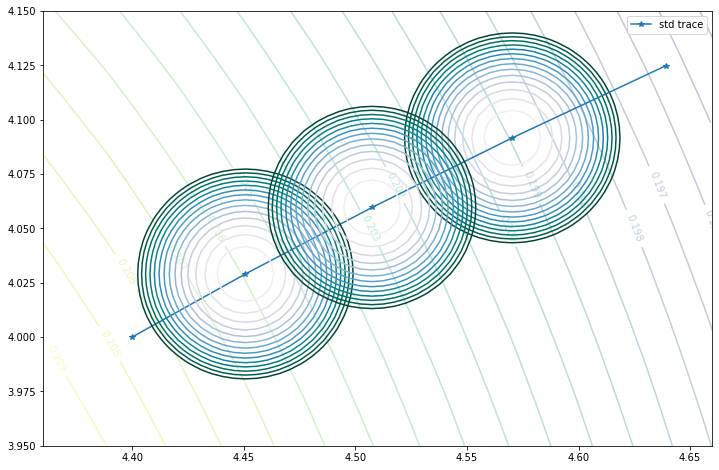

In [16]:
xrange = [4.36, 4.66];
yrange = [3.95, 4.15];
grid1 = (xrange[1]-xrange[0])/10;
grid2 = (yrange[1]-yrange[0])/10;
x = np.arange(xrange[0],xrange[1]+grid1,grid1);
y = np.arange(yrange[0],yrange[1]+grid2,grid2);
P,Q = np.meshgrid(x,y)
Z = np.zeros((x.size, y.size));
for i in range(x.size):
    for j in range(y.size):
        Z[i, j] = loss(X, 2, np.array([np.array([grid1*i+xrange[0], grid2*j+yrange[0]]), np.array([3, 2])]), 
                          np.array([.3]), ytruth);
fig, ax = plt.subplots(figsize=(12, 8));
level = np.arange(Z.min(), Z.max(), (Z.max()-Z.min())/20);
CS = ax.contour(P,Q,Z.T,levels = level, alpha=.3, zorder=0);
ax.clabel(CS, inline=True, fontsize=10);
plt.plot(std_steps[:, 0], std_steps[:, 1], '*-', label = 'std trace');
level1 = np.arange(Zstd1.min(), .2077, (Zstd1.max()-Zstd1.min())/30);
CS = ax.contour(Pstd1,Qstd1,Zstd1.T,levels = level1, alpha=1, zorder=5, cmap='PuBuGn');
level2 = np.arange(Zstd2.min(), .205, (Zstd2.max()-Zstd2.min())/30);
CS = ax.contour(Pstd2,Qstd2,Zstd2.T,levels = level2, alpha=1, zorder=10, cmap="PuBuGn");
level3 = np.arange(Zstd3.min(), .2019, (Zstd3.max()-Zstd3.min())/30);
CS = ax.contour(Pstd3,Qstd3,Zstd3.T,levels = level3, alpha=1, zorder=0, cmap="PuBuGn");
plt.xlim(4.36, 4.66);
plt.ylim(3.95, 4.15);
plt.legend();
savpath = "/Users/leiwanzhou/Desktop/l2_mix_4para/steps/std-steps-init4d44-lr1d5"
plt.savefig(savpath, dpi=300);

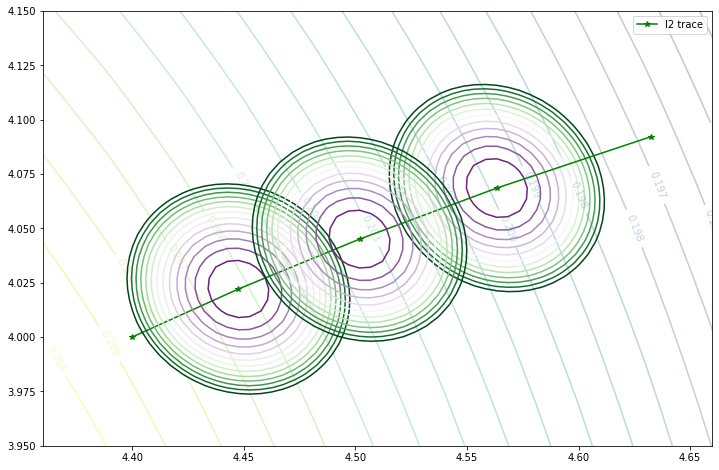

In [17]:
Pl21, Ql21, Zl21 = compute_contour(l2_steps[0], l2_steps[1], 
                          func_l2_mu1_appr, .05, 20, l2_lr);

Pl22, Ql22, Zl22 = compute_contour(l2_steps[1], l2_steps[2], 
                          func_l2_mu1_appr, .05, 20, l2_lr);

Pl23, Ql23, Zl23 = compute_contour(l2_steps[2], l2_steps[3], 
                          func_l2_mu1_appr, .05, 20, l2_lr);

xrange = [4.36, 4.66];
yrange = [3.95, 4.15];
grid1 = (xrange[1]-xrange[0])/10;
grid2 = (yrange[1]-yrange[0])/10;
x = np.arange(xrange[0],xrange[1]+grid1,grid1);
y = np.arange(yrange[0],yrange[1]+grid2,grid2);
P,Q = np.meshgrid(x,y)
Z = np.zeros((x.size, y.size));
for i in range(x.size):
    for j in range(y.size):
        Z[i, j] = loss(X, 2, np.array([np.array([grid1*i+xrange[0], grid2*j+yrange[0]]), np.array([3, 2])]), 
                          np.array([.3]), ytruth);
fig, ax = plt.subplots(figsize=(12, 8));
level = np.arange(Z.min(), Z.max(), (Z.max()-Z.min())/20);
CS = ax.contour(P,Q,Z.T,levels = level, alpha=.3, zorder=0);
ax.clabel(CS, inline=True, fontsize=10);
plt.plot(l2_steps[:, 0], l2_steps[:, 1], '*-', label = 'l2 trace', c='g');
level1 = np.arange(Zl21.min(), .2079, (Zl21.max()-Zl21.min())/30);
CS = ax.contour(Pl21,Ql21,Zl21.T,levels = level1, alpha=1, zorder=5, cmap='PRGn');
level2 = np.arange(Zl22.min(), .20545, (Zl22.max()-Zl22.min())/30);
CS = ax.contour(Pl22,Ql22,Zl22.T,levels = level2, alpha=1, zorder=10, cmap="PRGn");
level3 = np.arange(Zl23.min(), .202545, (Zl23.max()-Zl23.min())/30);
CS = ax.contour(Pl23,Ql23,Zl23.T,levels = level3, alpha=1, zorder=0, cmap="PRGn");
plt.xlim(4.36, 4.66);
plt.ylim(3.95, 4.15);
plt.legend();
savpath = "/Users/leiwanzhou/Desktop/l2_mix_4para/steps/l2-steps-init4d44-lrd1"
plt.savefig(savpath, dpi=300);

In [18]:
Pw21, Qw21, Zw21 = compute_contour(w2_steps[0], w2_steps[1], 
                          func_w2_mu1_appr, .075, 20, w2_lr);

Pw22, Qw22, Zw22 = compute_contour(w2_steps[1], w2_steps[2], 
                          func_w2_mu1_appr, .075, 20, w2_lr);

Pw23, Qw23, Zw23 = compute_contour(w2_steps[2], w2_steps[3], 
                          func_w2_mu1_appr, .075, 20, w2_lr);

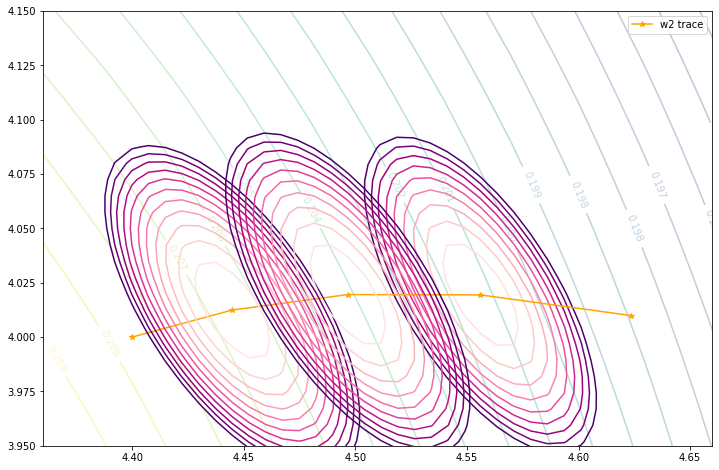

In [19]:
xrange = [4.36, 4.66];
yrange = [3.95, 4.15];
grid1 = (xrange[1]-xrange[0])/10;
grid2 = (yrange[1]-yrange[0])/10;
x = np.arange(xrange[0],xrange[1]+grid1,grid1);
y = np.arange(yrange[0],yrange[1]+grid2,grid2);
P,Q = np.meshgrid(x,y)
Z = np.zeros((x.size, y.size));
for i in range(x.size):
    for j in range(y.size):
        Z[i, j] = loss(X, 2, np.array([np.array([grid1*i+xrange[0], grid2*j+yrange[0]]), np.array([3, 2])]), 
                          np.array([.3]), ytruth);
fig, ax = plt.subplots(figsize=(12, 8));
level = np.arange(Z.min(), Z.max(), (Z.max()-Z.min())/20);
CS = ax.contour(P,Q,Z.T,levels = level, alpha=.3, zorder=0);
ax.clabel(CS, inline=True, fontsize=10);
plt.plot(w2_steps[:, 0], w2_steps[:, 1], '*-', label = 'w2 trace', c='orange');
level1 = np.arange(Zw21.min(), .2078, (Zw21.max()-Zw21.min())/100);
CS = ax.contour(Pw21,Qw21,Zw21.T,levels = level1, alpha=1, zorder=5, cmap='RdPu');
level2 = np.arange(Zw22.min(), .20578, (Zw22.max()-Zw22.min())/100);
CS = ax.contour(Pw22,Qw22,Zw22.T,levels = level2, alpha=1, zorder=10, cmap="RdPu");
level3 = np.arange(Zw23.min(), .203362, (Zw23.max()-Zw23.min())/100);
CS = ax.contour(Pw23,Qw23,Zw23.T,levels = level3, alpha=1, zorder=0, cmap="RdPu");
plt.xlim(4.36, 4.66);
plt.ylim(3.95, 4.15);
plt.legend();
savpath = "/Users/leiwanzhou/Desktop/l2_mix_4para/steps/w2-steps-init4d44-lr50"
plt.savefig(savpath, dpi=300);

In [20]:
initial = np.array([4.4, 4]); std_lr=15; w2_lr=500; l2_lr=1;
w = np.array([.3]);
std_steps = [initial];
w2_steps = [initial];
l2_steps = [initial];
std_para = initial; w2_para = initial; l2_para = initial;
for i in range(4):
    _,std_direct = gradient_mu1_all(X, w, std_para, np.array([3, 2]), ytruth);
    w2_direct = Natural_dir_mu1(X, N, w, 
                 np.array([w2_para, np.array([3, 2])]), ytruth, A, 2);
    l2_direct = l2_Natural_dirFull_mu1(X, np.array([l2_para, np.array([3, 2])]), 
                                    w, N, ytruth);
    std_para = std_para - std_lr*std_direct;
    w2_para = w2_para - w2_lr*w2_direct;
    l2_para = l2_para + l2_lr*l2_direct;
    std_steps.append(std_para);
    w2_steps.append(w2_para);
    l2_steps.append(l2_para);  
std_steps = np.array(std_steps);
w2_steps = np.array(w2_steps);
l2_steps = np.array(l2_steps);

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

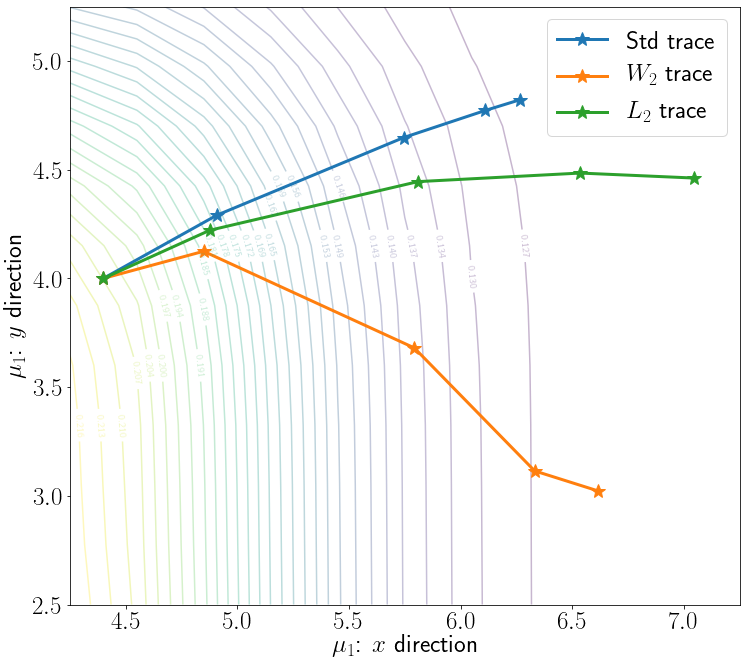

In [62]:
yrange = [2.5, 5.25];
xrange = [4.25, 7.25];
grid1 = (xrange[1]-xrange[0])/10;
grid2 = (yrange[1]-yrange[0])/10;
x = np.arange(xrange[0],xrange[1]+grid1,grid1);
y = np.arange(yrange[0],yrange[1]+grid2,grid2);
P,Q = np.meshgrid(x,y)
plt.rcParams.update({'font.size': 25})
Z = np.zeros((x.size, y.size));
for i in range(x.size):
    for j in range(y.size):
        Z[i, j] = loss(X, 2, np.array([np.array([grid1*i+xrange[0], grid2*j+yrange[0]]), np.array([3, 2])]), 
                          np.array([.3]), ytruth);
fig, ax = plt.subplots(figsize=(12, 11));
level = np.arange(Z.min(), Z.max(), (Z.max()-Z.min())/30);
CS = ax.contour(P,Q,Z.T,levels = level, alpha=.3, zorder=0);
ax.clabel(CS, inline=True, fontsize=10);
plt.plot(std_steps[:, 0], std_steps[:, 1], '*-', 
         label = 'Std trace', linewidth=3, markersize=15);
plt.plot(w2_steps[:, 0], w2_steps[:, 1], '*-', 
         label = r'$W_2$ trace', linewidth=3, markersize=15);
plt.plot(l2_steps[:, 0], l2_steps[:, 1], '*-', 
         label = r'$L_2$ trace', linewidth=3, markersize=15);
plt.xlim(4.25, 7.25);
plt.ylim(2.5, 5.25);
plt.xlabel(r"$\mu_1$: $x$ direction");
plt.ylabel(r"$\mu_1$: $y$ direction");
plt.legend();
savpath = "/Users/leiwanzhou/Desktop/l2_mix_4para/steps/together-trace-init4d44-lr15-500-1.eps"
plt.savefig(savpath, dpi=300);

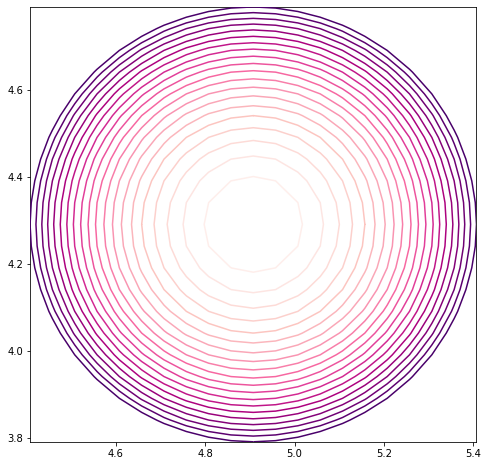

In [22]:
Pstd1, Qstd1, Zstd1 = compute_contour(std_steps[0], std_steps[1], 
                          func_std_mu1_appr, .5, 20, std_lr);

Pstd2, Qstd2, Zstd2 = compute_contour(std_steps[1], std_steps[2], 
                          func_std_mu1_appr, .5, 20, std_lr);

Pstd3, Qstd3, Zstd3 = compute_contour(std_steps[2], std_steps[3], 
                          func_std_mu1_appr, .5, 20, std_lr);

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

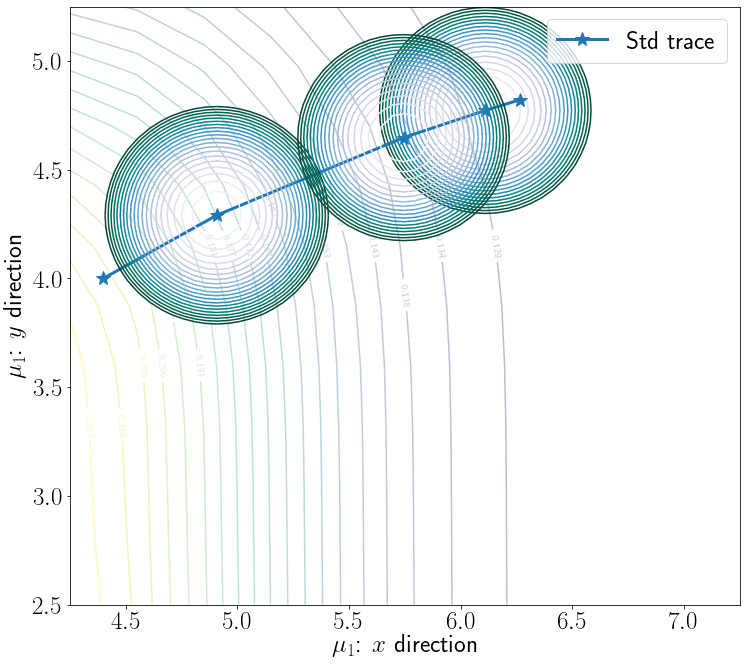

In [61]:
xrange = [4.25, 7.25];
yrange = [2.5, 5.25];
grid1 = (xrange[1]-xrange[0])/10;
grid2 = (yrange[1]-yrange[0])/10;
x = np.arange(xrange[0],xrange[1]+grid1,grid1);
y = np.arange(yrange[0],yrange[1]+grid2,grid2);
P,Q = np.meshgrid(x,y)
Z = np.zeros((x.size, y.size));
for i in range(x.size):
    for j in range(y.size):
        Z[i, j] = loss(X, 2, np.array([np.array([grid1*i+xrange[0], grid2*j+yrange[0]]), np.array([3, 2])]), 
                          np.array([.3]), ytruth);
fig, ax = plt.subplots(figsize=(12, 11));
level = np.arange(Z.min(), Z.max(), (Z.max()-Z.min())/20);
CS = ax.contour(P,Q,Z.T,levels = level, alpha=.3, zorder=0);
ax.clabel(CS, inline=True, fontsize=10);
plt.plot(std_steps[:, 0], std_steps[:, 1], '*-', 
         label = 'Std trace', linewidth=3, markersize=15);
level1 = np.arange(Zstd1.min(), .205, (Zstd1.max()-Zstd1.min())/40);
CS = ax.contour(Pstd1,Qstd1,Zstd1.T,levels = level1, alpha=1, zorder=5, cmap='PuBuGn');
level2 = np.arange(Zstd2.min(), .157, (Zstd2.max()-Zstd2.min())/40);
CS = ax.contour(Pstd2,Qstd2,Zstd2.T,levels = level2, alpha=1, zorder=10, cmap="PuBuGn");
level3 = np.arange(Zstd3.min(), .137, (Zstd3.max()-Zstd3.min())/40);
CS = ax.contour(Pstd3,Qstd3,Zstd3.T,levels = level3, alpha=1, zorder=0, cmap="PuBuGn");
plt.xlim(4.25, 7.25);
plt.ylim(2.5, 5.25);
plt.xlabel(r"$\mu_1$: $x$ direction");
plt.ylabel(r"$\mu_1$: $y$ direction");
plt.legend();
savpath = "/Users/leiwanzhou/Desktop/l2_mix_4para/steps/std-steps-init4d44-lr15.eps";
plt.savefig(savpath, dpi=300);

In [26]:
Pw21, Qw21, Zw21 = compute_contour(w2_steps[0], w2_steps[1], 
                          func_w2_mu1_appr, .5, 20, w2_lr);

Pw22, Qw22, Zw22 = compute_contour(w2_steps[1], w2_steps[2], 
                          func_w2_mu1_appr, .6, 30, w2_lr);

Pw23, Qw23, Zw23 = compute_contour(w2_steps[2], w2_steps[3], 
                          func_w2_mu1_appr, .7, 30, w2_lr);

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

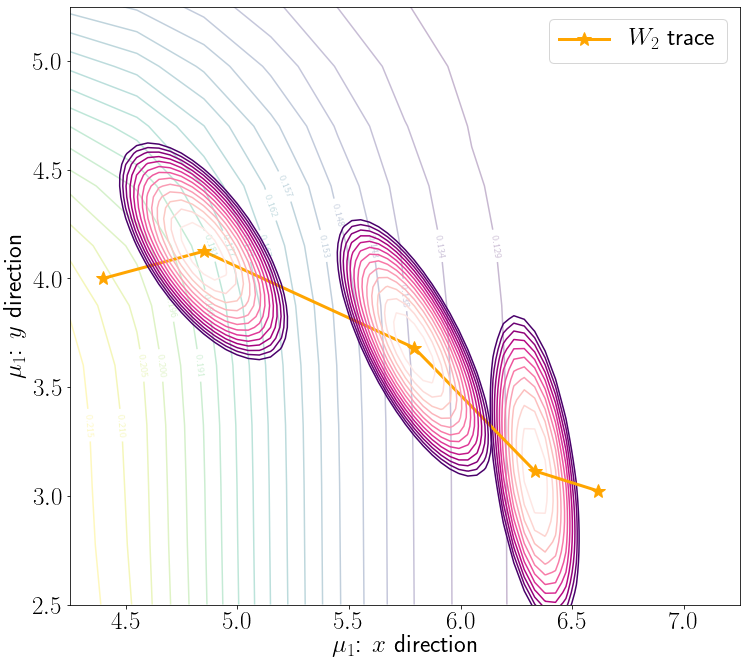

In [63]:
xrange = [4.25, 7.25];
yrange = [2.5, 5.25];
grid1 = (xrange[1]-xrange[0])/10;
grid2 = (yrange[1]-yrange[0])/10;
x = np.arange(xrange[0],xrange[1]+grid1,grid1);
y = np.arange(yrange[0],yrange[1]+grid2,grid2);
P,Q = np.meshgrid(x,y)
Z = np.zeros((x.size, y.size));
for i in range(x.size):
    for j in range(y.size):
        Z[i, j] = loss(X, 2, np.array([np.array([grid1*i+xrange[0], grid2*j+yrange[0]]), np.array([3, 2])]), 
                          np.array([.3]), ytruth);
fig, ax = plt.subplots(figsize=(12, 11));
level = np.arange(Z.min(), Z.max(), (Z.max()-Z.min())/20);
CS = ax.contour(P,Q,Z.T,levels = level, alpha=.3, zorder=0);
ax.clabel(CS, inline=True, fontsize=10);
plt.plot(w2_steps[:, 0], w2_steps[:, 1], '*-', 
         label = r'$W_2$ trace', c='orange', linewidth=3, markersize=15);
level1 = np.arange(Zw21.min(), .202, (Zw21.max()-Zw21.min())/100);
CS = ax.contour(Pw21,Qw21,Zw21.T,levels = level1, alpha=1, zorder=5, cmap='RdPu');
level2 = np.arange(Zw22.min(), .16301, (Zw22.max()-Zw22.min())/200);
CS = ax.contour(Pw22,Qw22,Zw22.T,levels = level2, alpha=1, zorder=10, cmap="RdPu");
level3 = np.arange(Zw23.min(), .1302, (Zw23.max()-Zw23.min())/250);
CS = ax.contour(Pw23,Qw23,Zw23.T,levels = level3, alpha=1, zorder=0, cmap="RdPu");
plt.xlim(4.25, 7.25);
plt.ylim(2.5, 5.25);
plt.xlabel(r"$\mu_1$: $x$ direction");
plt.ylabel(r"$\mu_1$: $y$ direction");
plt.legend();
savpath = "/Users/leiwanzhou/Desktop/l2_mix_4para/steps/w2-steps-init4d44-lr500.eps"
plt.savefig(savpath, dpi=300);

In [ ]:
Pl21, Ql21, Zl21 = compute_contour(l2_steps[0], l2_steps[1], 
                          func_l2_mu1_appr, .5, 30, l2_lr);

Pl22, Ql22, Zl22 = compute_contour(l2_steps[1], l2_steps[2], 
                          func_l2_mu1_appr, .6, 30, l2_lr);

Pl23, Ql23, Zl23 = compute_contour(l2_steps[2], l2_steps[3], 
                          func_l2_mu1_appr, .8, 40, l2_lr);

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

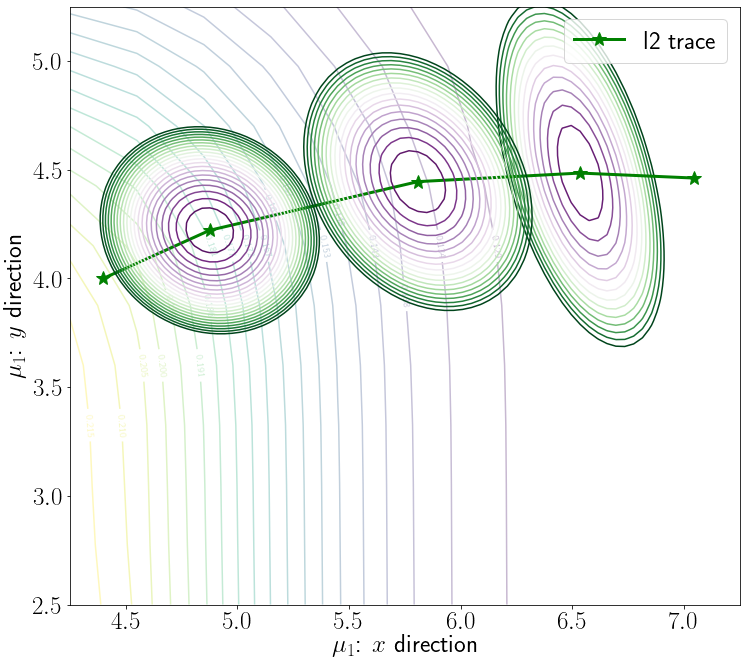

In [64]:
xrange = [4.25, 7.25];
yrange = [2.5, 5.25];
grid1 = (xrange[1]-xrange[0])/10;
grid2 = (yrange[1]-yrange[0])/10;
x = np.arange(xrange[0],xrange[1]+grid1,grid1);
y = np.arange(yrange[0],yrange[1]+grid2,grid2);
P,Q = np.meshgrid(x,y)
Z = np.zeros((x.size, y.size));
for i in range(x.size):
    for j in range(y.size):
        Z[i, j] = loss(X, 2, np.array([np.array([grid1*i+xrange[0], grid2*j+yrange[0]]), np.array([3, 2])]), 
                          np.array([.3]), ytruth);
fig, ax = plt.subplots(figsize=(12, 11));
level = np.arange(Z.min(), Z.max(), (Z.max()-Z.min())/20);
CS = ax.contour(P,Q,Z.T,levels = level, alpha=.3, zorder=0);
ax.clabel(CS, inline=True, fontsize=10);
plt.plot(l2_steps[:, 0], l2_steps[:, 1], '*-', 
         label = 'l2 trace', c='g', linewidth=3, markersize=15);
level1 = np.arange(Zl21.min(), .206, (Zl21.max()-Zl21.min())/50);
CS = ax.contour(Pl21,Ql21,Zl21.T,levels = level1, alpha=1, zorder=5, cmap='PRGn');
level2 = np.arange(Zl22.min(), .1585, (Zl22.max()-Zl22.min())/60);
CS = ax.contour(Pl22,Ql22,Zl22.T,levels = level2, alpha=1, zorder=10, cmap="PRGn");
level3 = np.arange(Zl23.min(), .12679, (Zl23.max()-Zl23.min())/130);
CS = ax.contour(Pl23,Ql23,Zl23.T,levels = level3, alpha=1, zorder=0, cmap="PRGn");
plt.xlim(4.25, 7.25);
plt.ylim(2.5, 5.25);
plt.xlabel(r"$\mu_1$: $x$ direction");
plt.ylabel(r"$\mu_1$: $y$ direction");
plt.legend();
savpath = "/Users/leiwanzhou/Desktop/l2_mix_4para/steps/l2-steps-init4d44-lr1.eps"
plt.savefig(savpath, dpi=300);